Import des librairies

In [1]:
import os
import dask.dataframe as dd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from dask import delayed
from sklearn.linear_model import LogisticRegression
from dask_ml.preprocessing import StandardScaler

path = os.getcwd()

Import du jeu de données

In [2]:
df = dd.read_table(path + "/fraudes.txt", sep=";", dtype={
       'CA3TRetMtt': 'float64',
       'CA3TR': 'float64',
       'CodeDecision': 'category',
       'D2CB': 'int64',
       'DiffDateTr1': 'float64',
       'DiffDateTr2': 'float64',
       'DiffDateTr3': 'float64',
       'EcartNumCheq': 'int64',
       'FlagImpaye': 'int64',
       'Heure': 'int64',
       'Montant': 'float64',
       'NbrMagasin3J': 'int64',
       'ScoringFP1': 'float64',
       'ScoringFP2': 'float64',
       'ScoringFP3': 'float64',
       'TauxImpNB_CPM': 'float64',
       'TauxImpNb_RB': 'float64',
       'VerifianceCPT1': 'int64',
       'VerifianceCPT2': 'int64',
       'VerifianceCPT3': 'int64'}, header=0, assume_missing=True, blocksize=940*1024*1024, parse_dates=['DateTransaction'])

In [3]:
#Suppression des colonnes liées aux variables qui n'apportent aucun intérêt.
df2 = df.iloc[:,2:]
df2 = df2.drop(['Heure', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'CA3TRetMtt'], axis=1)
df2['CodeDecision'] = df2['CodeDecision'].cat.as_known()
df2 = dd.get_dummies(df2)

In [4]:
# Aperçu des données
# df2.head()

Séparation entrainement / test

In [5]:
# Traiter la date pour couper le jeux en 2 - apprentissage / test
df2['DateTransaction'] = df2['DateTransaction'].map(lambda x: x.strftime('%Y-%m-%d'))

# Transformation en array car dask ne prend pas des df avec train_test_split
X_train = df2.iloc[:,1:].loc[df2['DateTransaction'] <= '2017-08-31']
y_train = df2['FlagImpaye'].loc[df2['DateTransaction'] <= '2017-08-31']
X_test = df2.iloc[:,1:].loc[df2['DateTransaction'] >= '2017-09-01']
y_test = df2['FlagImpaye'].loc[df2['DateTransaction'] >= '2017-09-01']

X_train = X_train.drop(['DateTransaction'], axis=1)
X_test = X_test.drop(['DateTransaction'], axis=1)

Normalisation des données

In [6]:
# Instanciation de StandardScaler pour centrer réduire les données
scaler = StandardScaler()

X_scale_train = scaler.fit_transform(X_train)
X_scale_test = scaler.fit_transform(X_test)

Après avoir réussi à gérer l'importation du dataset. Nous testons un premier algorithme sans technique d'échantillonnage et avec le solver par defaut. Avec la fonction delayed, nous pouvons accélérer les calculs et utiliser la parallélisation grâce à dask.

In [7]:
# Régression par défaut 'liblinear'
clf = LogisticRegression(random_state=0)

# Entrainement
delayed_fit = delayed(clf.fit)(X_scale_train, y_train)

In [8]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [9]:
# Lancement définitif du traitement sous dask
ypred_defaut = delayed_ypred.compute()
y_score_defaut = delayed_y_score.compute()

In [10]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_defaut)
cr = delayed(classification_report)(y_test, ypred_defaut)
roc = delayed(roc_auc_score)(y_test, ypred_defaut)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740838
           1       0.98      0.22      0.36      6573

    accuracy                           0.99    747411
   macro avg       0.99      0.61      0.68    747411
weighted avg       0.99      0.99      0.99    747411

Matrice de confusion :
 [[740814     24]
 [  5125   1448]]
Auc Score :
 0.6101313755331401


Dans un deuxième temps, mettons en place la régression logistique avec le solveur 'saga', recommandé pour les grands jeux de données.

In [11]:
# Régression avec solveur saga
clf = LogisticRegression(random_state=0, solver='saga')

# Entrainement
delayed_fit = delayed(clf.fit)(X_scale_train, y_train)

In [12]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [13]:
# Lancement définitif du traitement sous dask
ypred_saga = delayed_ypred.compute()
y_score_saga = delayed_y_score.compute()

In [14]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_saga)
cr = delayed(classification_report)(y_test, ypred_saga)
roc = delayed(roc_auc_score)(y_test, ypred_saga)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.96      0.65      0.77      6573

    accuracy                           1.00    747411
   macro avg       0.98      0.82      0.89    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740663    175]
 [  2310   4263]]
Auc Score :
 0.8241630406675208


Introduisons la régression penalisée LASSO avec le paramètre penalty = 'l1' en utilisant le solveur 'saga'.

In [15]:
# Régression LASSO
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', C=0.1)

# Entrainement
delayed_fit = delayed(clf.fit)(X_scale_train, y_train)

In [16]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [17]:
# Lancement définitif du traitement sous dask
ypred_lasso = delayed_ypred.compute()
y_score_lasso = delayed_y_score.compute()

In [18]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_lasso)
cr = delayed(classification_report)(y_test, ypred_lasso)
roc = delayed(roc_auc_score)(y_test, ypred_lasso)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.96      0.65      0.77      6573

    accuracy                           1.00    747411
   macro avg       0.98      0.82      0.89    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740664    174]
 [  2311   4262]]
Auc Score :
 0.8240876468127403


Testons la régression pénalisée RIDGE en basculant le paramètre penalty = 'l2'.

In [19]:
# Régression RIDGE
clf = LogisticRegression(random_state=0, penalty='l2', solver='saga', C=0.1)

# Entrainement
delayed_fit = delayed(clf.fit)(X_scale_train, y_train)

In [20]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [21]:
# Lancement définitif du traitement sous dask
ypred_ridge = delayed_ypred.compute()
y_score_ridge = delayed_y_score.compute()

In [22]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_ridge)
cr = delayed(classification_report)(y_test, ypred_ridge)
roc = delayed(roc_auc_score)(y_test, ypred_ridge)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.96      0.65      0.77      6573

    accuracy                           1.00    747411
   macro avg       0.98      0.82      0.89    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740663    175]
 [  2310   4263]]
Auc Score :
 0.8241630406675208


Testons la régression pénalisée ELASTICNET en basculant le paramètre penalty = 'elasticnet' avec un l1_ratio = 0.5 pour ne favoriser ni RIDGE, ni LASSO.

In [23]:
# Régression ELASTICNET
clf = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01)

# Entrainement
delayed_fit = delayed(clf.fit)(X_scale_train, y_train)

In [24]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [25]:
# Lancement définitif du traitement sous dask
ypred_elasticnet = delayed_ypred.compute()
y_score_elasticnet = delayed_y_score.compute()

In [26]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_elasticnet)
cr = delayed(classification_report)(y_test, ypred_elasticnet)
roc = delayed(roc_auc_score)(y_test, ypred_elasticnet)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.96      0.65      0.77      6573

    accuracy                           1.00    747411
   macro avg       0.98      0.82      0.89    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740666    172]
 [  2313   4260]]
Auc Score :
 0.8239368591031792


Essayons avec une stratégie d'oversampling avec l'algorithme SMOTE

In [27]:
# Mise en place d'une méthode d'oversampling SMOTE avant de séparer le jeu de données
from imblearn.over_sampling import SMOTE

# Nous cherchons à agrandir la classe minoritaire
method = SMOTE(random_state=0)
X_resampled, y_resampled = method.fit_resample(X_scale_train, y_train)

In [28]:
# Comptage des échantillons de la classe 'FlagImpaye'
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 3875940, 1: 3875940})


In [29]:
# Instanciation de l'objet
clf = LogisticRegression(random_state=0, solver='saga')

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled, y_resampled)

In [30]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [31]:
# Lancement définitif du traitement sous dask
ypred_smote = delayed_ypred.compute()
y_score_smote = delayed_y_score.compute()

In [32]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_smote)
cr = delayed(classification_report)(y_test, ypred_smote)
roc = delayed(roc_auc_score)(y_test, ypred_smote)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    740838
           1       0.16      0.79      0.27      6573

    accuracy                           0.96    747411
   macro avg       0.58      0.88      0.63    747411
weighted avg       0.99      0.96      0.97    747411

Matrice de confusion :
 [[714306  26532]
 [  1375   5198]]
Auc Score :
 0.8774986976797807


Utilisation de la méthode undersampling utilisée pour réduire la classe minoritaire.

In [33]:
# Mise en place d'une méthode d'undersampling avant de séparer le jeu de données
from imblearn.under_sampling import RandomUnderSampler

# Nous cherchons à agrandir la classe minoritaire
method = RandomUnderSampler(random_state=0)
X_resampled_under, y_resampled_under = method.fit_resample(X_scale_train, y_train)

In [34]:
# Comptage des échantillons de la classe 'FlagImpaye'
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_resampled_under))

Resampled dataset shape Counter({0: 23422, 1: 23422})


In [35]:
# Instanciation de l'objet
clf = LogisticRegression(random_state=0, solver='saga')

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled_under, y_resampled_under)

In [36]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [37]:
# Lancement définitif du traitement sous dask
ypred_under = delayed_ypred.compute()
y_score_under = delayed_y_score.compute()

In [38]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_under)
cr = delayed(classification_report)(y_test, ypred_under)
roc = delayed(roc_auc_score)(y_test, ypred_under)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    740838
           1       0.16      0.79      0.27      6573

    accuracy                           0.96    747411
   macro avg       0.58      0.88      0.62    747411
weighted avg       0.99      0.96      0.97    747411

Matrice de confusion :
 [[713537  27301]
 [  1384   5189]]
Auc Score :
 0.8762950719298992


Essayons de mettre en place une stratégie d'échantillonage SMOTE en mettant la classe minoritaire à 10% de la classe majoritaire.

In [39]:
# Mise en place d'une méthode d'oversampling SMOTE avant de séparer le jeu de données
from imblearn.over_sampling import SMOTE

# Nous cherchons à agrandir la classe minoritaire
method = SMOTE(random_state=0, sampling_strategy=0.1)
X_resampled_smote, y_resampled_smote = method.fit_resample(X_scale_train, y_train)

In [40]:
# Comptage des échantillons de la classe 'FlagImpaye'
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_resampled_smote))

Resampled dataset shape Counter({0: 3875940, 1: 387594})


In [41]:
# Instanciation de l'objet
clf = LogisticRegression(random_state=0, solver='saga')

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled_smote, y_resampled_smote)

In [42]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [43]:
# Lancement définitif du traitement sous dask
ypred_smote_10 = delayed_ypred.compute()
y_score_smote_10 = delayed_y_score.compute()

In [44]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_smote_10)
cr = delayed(classification_report)(y_test, ypred_smote_10)
roc = delayed(roc_auc_score)(y_test, ypred_smote_10)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.85      0.67      0.75      6573

    accuracy                           1.00    747411
   macro avg       0.92      0.84      0.87    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740026    812]
 [  2143   4430]]
Auc Score :
 0.8364366060653169


SMOTE 10% + RIDGE à 0.01

In [45]:
# Régression RIDGE
clf = LogisticRegression(random_state=0, penalty='l2', solver='saga', C=0.01)

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled_smote, y_resampled_smote)

In [46]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [47]:
# Lancement définitif du traitement sous dask
ypred_ridge_smote_10 = delayed_ypred.compute()
y_score_ridge_smote_10 = delayed_y_score.compute()

In [48]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_ridge_smote_10)
cr = delayed(classification_report)(y_test, ypred_ridge_smote_10)
roc = delayed(roc_auc_score)(y_test, ypred_ridge_smote_10)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.85      0.67      0.75      6573

    accuracy                           1.00    747411
   macro avg       0.92      0.84      0.87    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740029    809]
 [  2143   4430]]
Auc Score :
 0.8364386307994692


SMOTE 10% + LASSO à 0.01

In [49]:
# Régression LASSO
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', C=0.01)

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled_smote, y_resampled_smote)

In [50]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [51]:
# Lancement définitif du traitement sous dask
ypred_lasso_smote_10 = delayed_ypred.compute()
y_score_lasso_smote_10 = delayed_y_score.compute()

In [52]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_lasso_smote_10)
cr = delayed(classification_report)(y_test, ypred_lasso_smote_10)
roc = delayed(roc_auc_score)(y_test, ypred_lasso_smote_10)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.85      0.67      0.75      6573

    accuracy                           1.00    747411
   macro avg       0.92      0.84      0.87    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740034    804]
 [  2138   4435]]
Auc Score :
 0.836822349187213


SMOTE 10% avec ELASTICNET 0.01

In [53]:
# Régression ELASTICNET
clf = LogisticRegression(random_state=0, penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.01)

# Entrainement
delayed_fit = delayed(clf.fit)(X_resampled_smote, y_resampled_smote)

In [54]:
# Prédiction
delayed_ypred = delayed(delayed_fit.predict)(X_scale_test)
delayed_y_score = delayed(delayed_fit.predict_proba)(X_scale_test)

In [55]:
# Lancement définitif du traitement sous dask
ypred_elasticnet_smote_10 = delayed_ypred.compute()
y_score_elasticnet_smote_10 = delayed_y_score.compute()

In [56]:
# Estimateurs, matrice de confusion et AUC
cm = delayed(confusion_matrix)(y_test, ypred_elasticnet_smote_10)
cr = delayed(classification_report)(y_test, ypred_elasticnet_smote_10)
roc = delayed(roc_auc_score)(y_test, ypred_elasticnet_smote_10)

print('Estimateurs :\n', cr.compute())
print('Matrice de confusion :\n', cm.compute())
print('Auc Score :\n', roc.compute())

Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740838
           1       0.85      0.67      0.75      6573

    accuracy                           1.00    747411
   macro avg       0.92      0.84      0.87    747411
weighted avg       1.00      1.00      1.00    747411

Matrice de confusion :
 [[740031    807]
 [  2141   4432]]
Auc Score :
 0.8365921181545668


Quelques courbes pour présenter les résultats.

1/ Courbe ROC

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

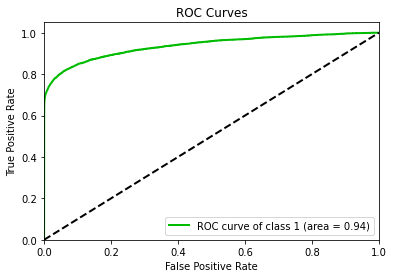

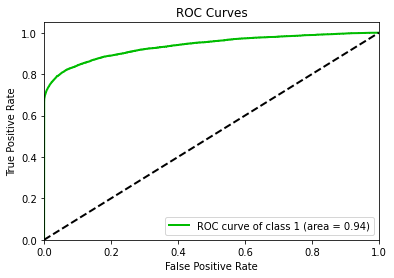

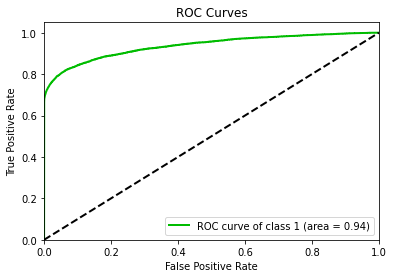

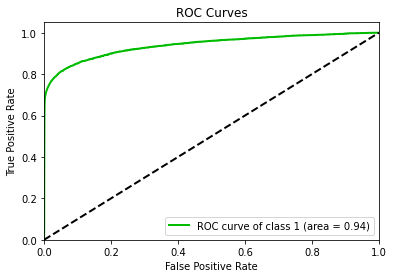

In [57]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, y_score_defaut, classes_to_plot = 1, plot_micro = False, plot_macro = False)
skplt.metrics.plot_roc(y_test, y_score_saga, classes_to_plot = 1, plot_micro = False, plot_macro = False)
skplt.metrics.plot_roc(y_test, y_score_elasticnet, classes_to_plot = 1, plot_micro = False, plot_macro = False)
skplt.metrics.plot_roc(y_test, y_score_smote, classes_to_plot = 1, plot_micro = False, plot_macro = False)

2/ Courbe Précision-Rappel

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

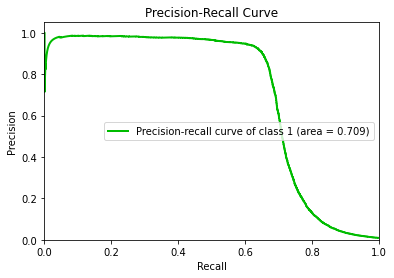

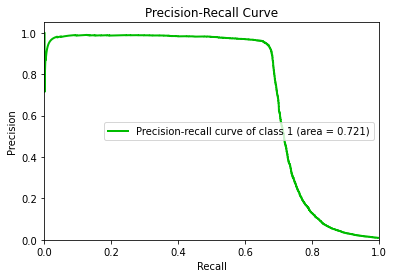

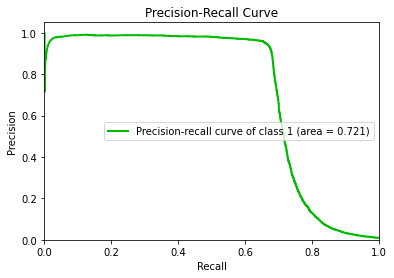

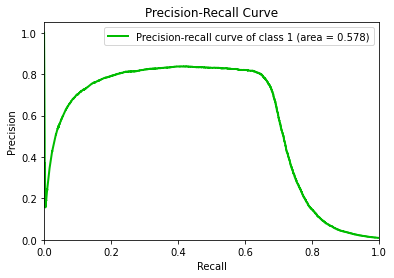

In [58]:
skplt.metrics.plot_precision_recall(y_test, y_score_defaut, classes_to_plot = 1, plot_micro = False)
skplt.metrics.plot_precision_recall(y_test, y_score_saga, classes_to_plot = 1, plot_micro = False)
skplt.metrics.plot_precision_recall(y_test, y_score_elasticnet, classes_to_plot = 1, plot_micro = False)
skplt.metrics.plot_precision_recall(y_test, y_score_smote, classes_to_plot = 1, plot_micro = False)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

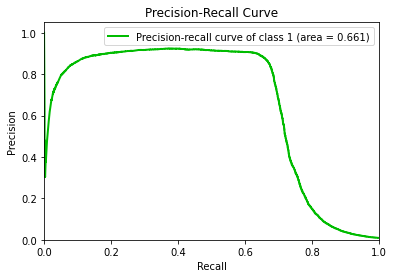

In [64]:
skplt.metrics.plot_precision_recall(y_test, y_score_elasticnet_smote_10, classes_to_plot = 1, plot_micro = False)

In [65]:
# Sauvegarde du modèle
import pickle

f = open("LogReg.sav", "wb")
pickle.dump(ypred_elasticnet_smote_10, f)
f.close()

Utilisation de la méthode SMOTEENN (SMOTE Edited Nearest Neighbours) utilisée pour une combinaison d'over et d'under-sampling et se basant sur une technique de plus proche voisins.

In [60]:

# Abandon de la technnique SMOTEENN beaucoup trop longue (1 nuit complète + pc planté) !
# from imblearn.combine import SMOTEENN

# method = SMOTEENN(random_state=0)
# X_resampled_SMOTEENN, y_resampled_SMOTEENN = method.fit_resample(X_scale_train, y_train)

Testons enfin la méthode d'échantillonnage TomekLinks qui forment des paires sur les étiquettes différentes. De ce fait, nous favorisons la suppression des individus proches de la frontière de décision qui peuvent amener à une mauvaise classification. (Il semble lui aussi très long à lancer.)
Après un nuit complète, l'algo ne s'étant pas terminé, nous l'avons arrêté.

In [61]:

# Mise en place d'une méthode d'undersampling avant de séparer le jeu de données
# from imblearn.under_sampling import TomekLinks

# Nous cherchons à supprimer les individus de la classe prédite différente afin de ne retenir que les individus évidents.
# method = TomekLinks()
# X_resampled_tomek, y_resampled_tomek = method.fit_resample(X_scale_train, y_train)

Préparation de la courbe ROC de tous les modèles

In [62]:
# # Roc Curve
# from sklearn.metrics import roc_curve

# # Taux de vrais / faux positifs par algorithme pour la construction de la courbe ROC
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_defaut)
# false_positive_rate_saga, true_positive_rate_saga, threshold_saga = roc_curve(y_test, y_score_saga)
# false_positive_rate_ridge, true_positive_rate_ridge, threshold_ridge = roc_curve(y_test, y_score_ridge)
# false_positive_rate_lasso, true_positive_rate_lasso, threshold_lasso = roc_curve(y_test, y_score_lasso)
# false_positive_rate_elasticnet, true_positive_rate_elasticnet, threshold_elasticnet = roc_curve(y_test, y_score_elasticnet)
# false_positive_rate_under, true_positive_rate_under, threshold_under = roc_curve(y_test, y_score_under)
# false_positive_rate_smote, true_positive_rate_smote, threshold_smote = roc_curve(y_test, y_score_smote)
# false_positive_rate_smote_10, true_positive_rate_smote_10, threshold_smote_10 = roc_curve(y_test, y_score_smote_10)
# false_positive_rate_ridge_smote, true_positive_rate_ridge_smote, threshold_ridge_smote = roc_curve(y_test, y_score_ridge_smote_10)
# false_positive_rate_lasso_smote, true_positive_rate_lasso_smote, threshold_lasso_smote = roc_curve(y_test, y_score_lasso_smote_10)
# false_positive_rate_elasticnet_smote, true_positive_rate_elasticnet_smote, threshold_elasticnet_smote = roc_curve(y_test, y_score_elasticnet_smote_10)

Affichage des courbes ROC

In [63]:
# from matplotlib import pyplot as plt

# plt.subplots(1, figsize=(10,10))
# plt.title('Courbe ROC - Logistic Regression')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot(false_positive_rate_saga, true_positive_rate_saga)
# plt.plot(false_positive_rate_ridge, true_positive_rate_ridge)
# plt.plot(false_positive_rate_lasso, true_positive_rate_lasso)
# plt.plot(false_positive_rate_elasticnet, true_positive_rate_elasticnet)
# plt.plot(false_positive_rate_under, true_positive_rate_under)
# plt.plot(false_positive_rate_smote, true_positive_rate_smote)
# plt.plot(false_positive_rate_smote_10, true_positive_rate_smote_10)
# plt.plot(false_positive_rate_ridge_smote, true_positive_rate_ridge_smote)
# plt.plot(false_positive_rate_lasso_smote, true_positive_rate_lasso_smote)
# plt.plot(false_positive_rate_elasticnet_smote, true_positive_rate_elasticnet_smote)
# plt.plot([0, 1], ls="--")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()